In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (
    LinearRegression, 
    PoissonRegressor, 
    GammaRegressor, 
    TweedieRegressor, 
    LogisticRegression
)
from sklearn.metrics import (
    accuracy_score, 
    recall_score, 
    precision_score, 
    f1_score,
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    roc_auc_score, 
    classification_report
)
from sklearn.utils.validation import check_is_fitted
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import RFECV
from sklearn.linear_model import ElasticNet, LogisticRegression

In [33]:
# test data 

np.random.seed(1)
n_samples = 8000

# numeric features
age = np.random.randint(18, 70, n_samples)
income = np.random.normal(50000, 15000, n_samples)
num_transactions = np.random.poisson(10, n_samples)

# categorical features
gender = np.random.choice(['Male', 'Female'], n_samples)
region = np.random.choice(['North', 'South', 'East', 'West'], n_samples)
product_type = np.random.choice(['A', 'B', 'C'], n_samples)

# continuous target (for regressors)
target_continuous = 0.05 * age + 0.0005 * income + 0.3 * num_transactions + np.random.normal(0, 2, n_samples)

# binary classification target (for logistic regression)
target_binary = (target_continuous > np.median(target_continuous)).astype(int)

# combine into one dataframe
df = pd.DataFrame({
    'age': age,
    'income': income,
    'num_transactions': num_transactions,
    'gender': gender,
    'region': region,
    'product_type': product_type,
    'target': target_continuous  # can switch to target_binary if you want classification only
})

In [34]:
# Load Data
#df = pd.read_csv("data.csv")
X = df.drop("target", axis=1)
y = df["target"]

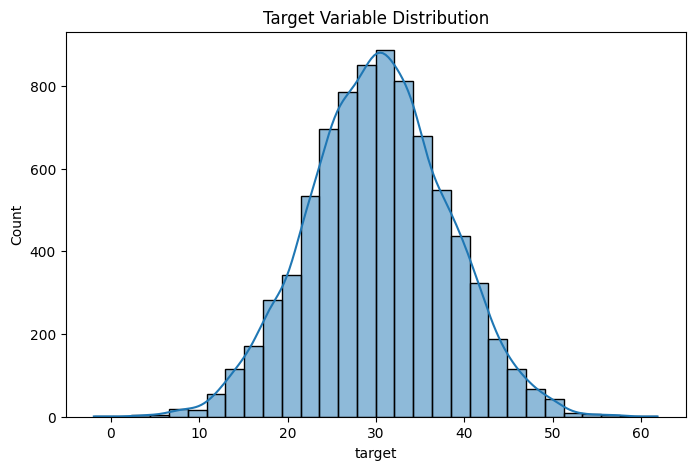

Skewness: -0.0007525204507180382
Kurtosis: 0.017704361791539114


In [35]:
# Distribution

plt.figure(figsize=(8, 5))
sns.histplot(y, kde=True, bins=30)
plt.title("Target Variable Distribution")
plt.show()

print("Skewness:", y.skew())
print("Kurtosis:", y.kurt())

In [36]:
# Train/Test Split

try:
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
except ValueError:
    # if y is continuous
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )


In [37]:
# Preprocessing

numeric_features = ['age', 'income', 'num_transactions']
categorical_features = ['gender', 'region', 'product_type']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [38]:
# Parameter Grids

models = {
    "LinearRegression": (LinearRegression(), {
        # no hyperparameters to tune for LinearRegression
    }),
    "PoissonRegressor": (PoissonRegressor(max_iter=1000), {
        "clf__alpha": [0.001, 0.01, 0.1, 1.0],
    }),
    "GammaRegressor": (GammaRegressor(max_iter=1000), {
        "clf__alpha": [0.001, 0.01, 0.1, 1.0],
    }),
    "TweedieRegressor": (TweedieRegressor(max_iter=1000), {
        "clf__power": [0, 1, 1.5, 1.8, 2],
        "clf__alpha": [0.001, 0.01, 0.1, 1.0],
    }),
    "LogisticRegression": (LogisticRegression(
        solver="saga", penalty="elasticnet", max_iter=2000, random_state=1
    ), {
        "clf__C": np.logspace(-4, 2, 10),
        "clf__l1_ratio": [0, 0.25, 0.5, 0.75, 1.0]
    })
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) if len(y.unique()) < 10 else KFold(n_splits=5, shuffle=True, random_state=1)

In [39]:
# Training & Evaluation

def train_models(X_train, y_train, X_test, y_test, selection_method=None):
    """
    Train multiple GLM models with optional feature selection.

    selection_method: None, 'elasticnet', or 'rfecv'
    """
    results = []
    fitted_pipelines = []

    for name, (model, params) in models.items():
        print(f"\n🔹 Training {name}...")

        # Skip Poisson/Gamma/Tweedie if target has non-positive values
        if isinstance(model, (PoissonRegressor, GammaRegressor, TweedieRegressor)) and (y_train <= 0).any():
            print(f"⚠️ Skipping {name} due to non-positive target values")
            continue

        pipe = Pipeline([("prep", preprocessor), ("clf", model)])

        # Apply feature selection if requested
        if selection_method == 'elasticnet':
            if "Logistic" in name:
                sel_model = LogisticRegression(
                    solver="saga", penalty="elasticnet", l1_ratio=0.5, C=1.0, max_iter=2000
                )
            else:
                sel_model = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=2000)
            # Wrap selection in pipeline
            pipe = Pipeline([("prep", preprocessor), ("selector", sel_model), ("clf", model)])
            print("💡 Using ElasticNet for feature selection")

        elif selection_method == 'rfecv':
            # RFECV requires estimator supporting coef_
            if "Logistic" in name:
                estimator = LogisticRegression(solver="liblinear", max_iter=2000)
            else:
                estimator = LinearRegression()
            rfecv = RFECV(estimator=estimator, step=1, cv=5, scoring='r2' if "Logistic" not in name else 'roc_auc')
            pipe = Pipeline([("prep", preprocessor), ("selector", rfecv), ("clf", model)])
            print("💡 Using RFECV for feature selection")

        scoring = "roc_auc" if "Logistic" in name else "r2"

        grid = GridSearchCV(pipe, param_grid=params, cv=cv, n_jobs=-1, scoring=scoring, return_train_score=False)

        try:
            y_train_use = y_train if "Logistic" not in name else (y_train > np.median(y_train)).astype(int)
            y_test_use = y_test if "Logistic" not in name else (y_test > np.median(y_test)).astype(int)

            grid.fit(X_train, y_train_use)
            best_model = grid.best_estimator_
            fitted_pipelines.append(best_model)
            y_pred = best_model.predict(X_test)

            # Metrics
            if "Logistic" in name:
                y_pred_binary = (y_pred > 0.5).astype(int)
                metrics = {
                    "Model": name,
                    "Best Params": grid.best_params_,
                    "Accuracy": accuracy_score(y_test_use, y_pred_binary),
                    "Recall": recall_score(y_test_use, y_pred_binary),
                    "Precision": precision_score(y_test_use, y_pred_binary),
                    "F1 Score": f1_score(y_test_use, y_pred_binary),
                    "RMSE": np.sqrt(mean_squared_error(y_test_use, y_pred)),
                    "MAE": mean_absolute_error(y_test_use, y_pred),
                    "R² Score": r2_score(y_test_use, y_pred),
                }
            else:
                n = len(y_test_use)
                p = X_train.shape[1]
                rss = np.sum((y_test_use - y_pred) ** 2)
                mse = mean_squared_error(y_test_use, y_pred)
                aic = n * np.log(rss / n) + 2 * p
                bic = n * np.log(rss / n) + p * np.log(n)
                metrics = {
                    "Model": name,
                    "Best Params": grid.best_params_,
                    "RMSE": np.sqrt(mse),
                    "MAE": mean_absolute_error(y_test_use, y_pred),
                    "R² Score": r2_score(y_test_use, y_pred),
                    "AIC": aic,
                    "BIC": bic
                }

            results.append(metrics)
        except Exception as e:
            print(f"⚠️ Skipping {name} due to error: {e}")
            continue

    return results, fitted_pipelines

In [ ]:
# No feature selection
# results, pipelines = train_models(X_train_full, y_train_full, X_test, y_test, selection_method=None)

# ElasticNet → unimportant features get near-zero weights.
#results, pipelines = train_models(X_train_full, y_train_full, X_test, y_test, selection_method='elasticnet')

# RFECV → removes features that do not improve cross-validated performance.
results, pipelines = train_models(X_train_full, y_train_full, X_test, y_test, selection_method='rfecv')



🔹 Training LinearRegression...
💡 Using RFECV for feature selection

🔹 Training PoissonRegressor...
⚠️ Skipping PoissonRegressor due to non-positive target values

🔹 Training GammaRegressor...
⚠️ Skipping GammaRegressor due to non-positive target values

🔹 Training TweedieRegressor...
⚠️ Skipping TweedieRegressor due to non-positive target values

🔹 Training LogisticRegression...
💡 Using RFECV for feature selection


In [42]:
# Results Summary

results_df = pd.DataFrame(results)
transposed_df = results_df.set_index('Model').T
print("\n✅ Model Evaluation Summary:")
print(transposed_df)



✅ Model Evaluation Summary:
Model       LinearRegression  \
Best Params               {}   
RMSE                1.976643   
MAE                 1.579435   
R² Score            0.937143   
AIC              2192.480228   
BIC              2224.746782   
Accuracy                 NaN   
Recall                   NaN   
Precision                NaN   
F1 Score                 NaN   

Model                                       LogisticRegression  
Best Params  {'clf__C': 0.00046415888336127773, 'clf__l1_ra...  
RMSE                                                  0.280624  
MAE                                                    0.07875  
R² Score                                                 0.685  
AIC                                                        NaN  
BIC                                                        NaN  
Accuracy                                               0.92125  
Recall                                                 0.90375  
Precision                        

In [41]:
def plot_pred_vs_actual(model, X_train, y_train, X_test, y_test, name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    plt.figure(figsize=(12,5))
    # Train
    plt.subplot(1,2,1)
    sns.scatterplot(x=y_train, y=y_train_pred)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    plt.xlabel("Actual Train"); plt.ylabel("Predicted Train")
    plt.title(f"{name} - Train Predictions")

    # Test
    plt.subplot(1,2,2)
    sns.scatterplot(x=y_test, y=y_test_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Test"); plt.ylabel("Predicted Test")
    plt.title(f"{name} - Test Predictions")
    
    plt.tight_layout()
    plt.show()

def plot_residuals(model, X, y, name):
    y_pred = model.predict(X)
    residuals = y - y_pred
    plt.figure(figsize=(6,4))
    sns.histplot(residuals, kde=True)
    plt.title(f"{name} - Residuals Distribution")
    plt.xlabel("Residuals")
    plt.show()

def print_model_coefficients(model):
    try:
        coef = model.named_steps['clf'].coef_
        feature_names = model.named_steps['prep'].get_feature_names_out()
        coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef.flatten()})
        coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)
        print("\n🔹 Model Coefficients:")
        print(coef_df)
    except Exception as e:
        print(f"Cannot extract coefficients: {e}")


🏆 Best Regression Model: LinearRegression

🔹 Model Coefficients:
                  Feature  Coefficient
1             num__income     7.435216
2   num__num_transactions     0.968039
0                num__age     0.736403
6       cat__region_North    -0.087445
5        cat__region_East     0.057861
8        cat__region_West     0.046488
3      cat__gender_Female    -0.045652
4        cat__gender_Male     0.045652
7       cat__region_South    -0.016905
11    cat__product_type_C    -0.013639
9     cat__product_type_A     0.009126
10    cat__product_type_B     0.004513


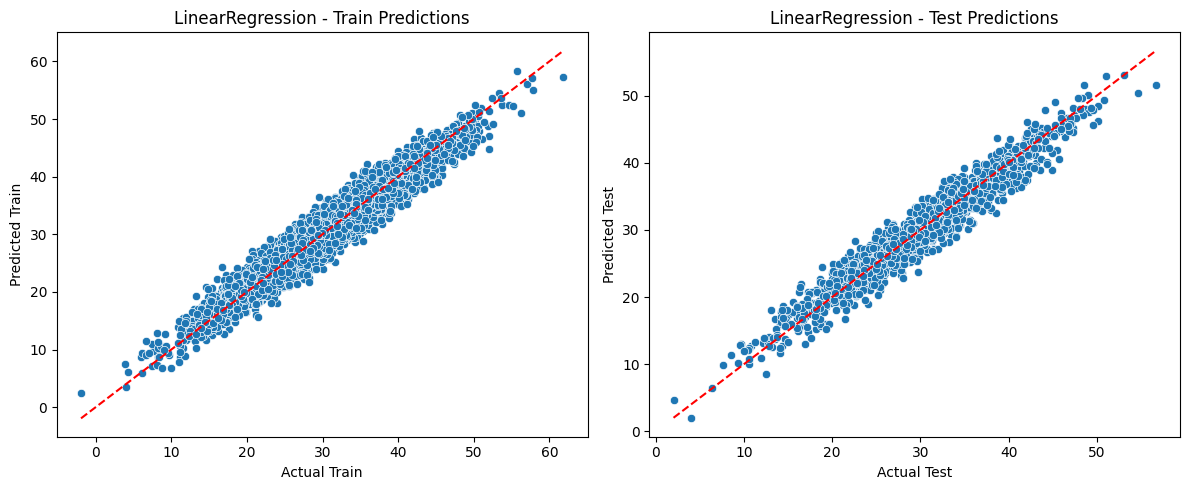

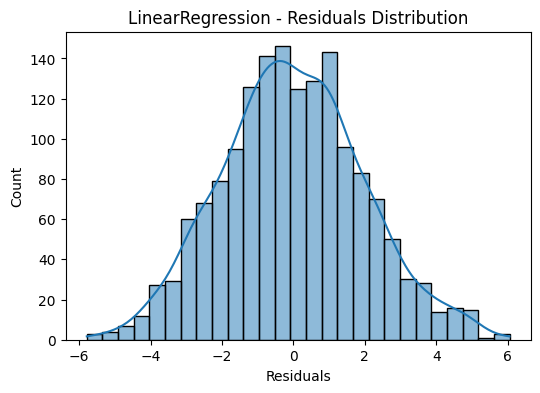

In [43]:
# Best Regression Model by R²

regression_results = [r for r in results if 'R² Score' in r]
best_model_name = max(regression_results, key=lambda x: x['R² Score'])['Model']
best_model_index = [i for i, r in enumerate(results) if r['Model']==best_model_name][0]
best_model_pipeline = fitted_pipelines[best_model_index]

print(f"\n🏆 Best Regression Model: {best_model_name}")

# Coefficients
print_model_coefficients(best_model_pipeline)

# Train vs Test plot
plot_pred_vs_actual(best_model_pipeline, X_train_full, y_train_full, X_test, y_test, best_model_name)

# Residuals plot
plot_residuals(best_model_pipeline, X_test, y_test, best_model_name)

In [ ]:
# more visuals??? 